In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
from epiweeks import Week

In [2]:
def compute_delta_death(confile1, confile2, path):
    # 2 is the one removing vaccine
    death_sim=np.load(path+confile1)["arr_0"]
    death_sim2=np.load(path+confile2)["arr_0"]
    delta_death=[]
    perc_delta_death=[]
    for i in range(len(death_sim)):
        dd=death_sim2[i]-death_sim[i]
        delta_death.append(sum(dd))
        perc_delta_death.append(sum(dd)/sum(death_sim2[i])*100)
    return delta_death, perc_delta_death

In [3]:
def calculate_reductions(df, region):


    # add week of year 
    df.date = pd.to_datetime(df.date)
    year_week = []
    for i in range(df.shape[0]):
        if df.date[i].isocalendar()[1] < 10:    
            year_week.append(str(df.date[i].isocalendar()[0]) + "-0" + str(df.date[i].isocalendar()[1]))
        else: 
            year_week.append(str(df.date[i].isocalendar()[0]) + "-" + str(df.date[i].isocalendar()[1]))
    df["year_week"] = year_week
    # loc basin and sort by date
    df.sort_values(by="date", inplace=True)
    #df_basin = df_basin.loc[df_basin.year_week <= "2021-09"].reset_index(drop=True)

    # work and other_loc columns
    work_cols      = ["workplaces_percent_change_from_baseline"]
    other_loc_cols = ["retail_and_recreation_percent_change_from_baseline",
                      "transit_stations_percent_change_from_baseline"]
    
    # loc work columns, fix weekends, compute contacts reduction
    df["work_red"] = df[work_cols].mean(axis=1)
    df.loc[df.date.dt.weekday==5, "work_red"] = df["work_red"].shift(1)
    df.loc[df.date.dt.weekday==6, "work_red"] = df["work_red"].shift(1)

    # loc oth columns, compute contacts reduction
    df["oth_red"] = df[other_loc_cols].mean(axis=1)

    df["average_reductions"]=(1 + (df["oth_red"]+df["work_red"])/2 / 100)**2
    group_by = df.groupby(by="year_week")["average_reductions"].mean()
    return group_by

In [4]:
### compute reductions

In [5]:
region='London'
df21_london = pd.read_excel("..\\data\\mobility_raw\\Google Mobility\\2021_" + region + "_Region_Mobility_Report.xlsx")
df20_london = pd.read_excel("..\\data\\mobility_raw\\Google Mobility\\2020_" + region + "_Region_Mobility_Report.xlsx")
df_london = pd.concat((df20_london, df21_london)).reset_index(drop=True)

In [6]:
region='Lombardy'
df21_lom = pd.read_csv("..\\data\\mobility_raw\\Google Mobility\\2021_" + region + "_Region_Mobility_Report.csv")
df20_lom = pd.read_csv("..\\data\\mobility_raw\\Google Mobility\\2020_" + region + "_Region_Mobility_Report.csv")
df_lom = pd.concat((df20_lom, df21_lom)).reset_index(drop=True)

In [7]:
region='Sao Paulo'
df21_sp = pd.read_csv("..\\data\\mobility_raw\\Google Mobility\\2021_" + region + "_Region_Mobility_Report.csv")
df20_sp = pd.read_csv("..\\data\\mobility_raw\\Google Mobility\\2020_" + region + "_Region_Mobility_Report.csv")
df_sp = pd.concat((df20_sp, df21_sp)).reset_index(drop=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_46648\3566221425.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df21_sp = pd.read_csv("..\\data\\mobility_raw\\Google Mobility\\2021_" + region + "_Region_Mobility_Report.csv")
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_46648\3566221425.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df20_sp = pd.read_csv("..\\data\\mobility_raw\\Google Mobility\\2020_" + region + "_Region_Mobility_Report.csv")


In [8]:
region='British Columbia'
df21_bc = pd.read_csv("..\\data\\mobility_raw\\Google Mobility\\2021_" + region + "_Region_Mobility_Report.csv")
df20_bc = pd.read_csv("..\\data\\mobility_raw\\Google Mobility\\2020_" + region + "_Region_Mobility_Report.csv")
df_bc = pd.concat((df20_bc, df21_bc)).reset_index(drop=True)

In [9]:
reduction_london=calculate_reductions(df_london, 'London')
reduction_lom=calculate_reductions(df_lom, 'Lombardy')
reduction_sp=calculate_reductions(df_sp, 'Sao Paulo')
reduction_bc=calculate_reductions(df_bc, 'British Columbia')

In [10]:
### 70 years group

In [11]:
dfold_bc2=pd.read_csv("..\\data\\regions\\British Columbia\\epidemic\\vac_1st_age_correct_ver(agegroup_adjust).csv")
pop=pd.read_excel("..\\data\\regions\\British Columbia\\demographic\\pop_5years.xlsx")

dfold_bc2_1=dfold_bc2.loc[dfold_bc2['age']=='70–79']
dfold_bc2_2=dfold_bc2.loc[dfold_bc2['age']=='80+']
dfold_bc2=pd.DataFrame(data=None,columns=['date','rV'])
dfold_bc2['date']=dfold_bc2_1['week_end']
dfold_bc2['rV'] = (dfold_bc2_1['rV'].values*pop.loc[pop['Age']=='70-74']['total'].values
                   +dfold_bc2_2['rV'].values*pop.loc[pop['Age']=='75+']['total'].values)/(pop.loc[pop['Age']=='70-74']['total'].values+pop.loc[pop['Age']=='75+']['total'].values)
#dfold_bc2
# dfold_bc2=pd.concat([dfold_bc2_1, dfold_bc2_2])
# dfold_bc2.rename(columns={'week_end':'date'},inplace=True)
# dfold_bc2=dfold_bc2.groupby('date').agg({'rV':'sum'})
# dfold_bc2.reset_index(inplace=True)
dfold_bc2=dfold_bc2.loc[dfold_bc2['date']<="2021-07-04"]
dfold_bc2['accumulated_rV'] = dfold_bc2['rV'].cumsum()
dfold_bc2

,date,rV,accumulated_rV
2,2020-12-19,0.000048,0.000048
6,2020-12-20,0.000224,0.000272
10,2020-12-21,0.000224,0.000495
14,2020-12-22,0.000224,0.000719
18,2020-12-23,0.000224,0.000942
...,...,...,...
1162,2021-06-30,0.000820,0.973433
1172,2021-07-01,0.000820,0.974253
1182,2021-07-02,0.000820,0.975073
1192,2021-07-03,0.000820,0.975893


In [12]:
dfold_lom2=pd.read_csv("..\\data\\regions\\Lombardy\\epidemic\\vac_1st_age_correct_ver(agegroup_adjust).csv")
pop=pd.read_excel("..\\data\\demographic_raw\\lombardy_10year_age_group(for vaccine).xlsx")

dfold_lom2_1=dfold_lom2.loc[dfold_lom2['age']=='70-79']
dfold_lom2_2=dfold_lom2.loc[dfold_lom2['age']=='80-89']
dfold_lom2_3=dfold_lom2.loc[dfold_lom2['age']=='90+']
dfold_lom2=pd.DataFrame(data=None,columns=['date','rV'])
dfold_lom2['date']=dfold_lom2_1['date']
dfold_lom2['rV'] = (dfold_lom2_1['rV'].values*pop.loc[pop['Age']=='70-79']['total'].values
                   +dfold_lom2_2['rV'].values*pop.loc[pop['Age']=='80-89']['total'].values
                   +dfold_lom2_2['rV'].values*pop.loc[pop['Age']=='90+']['total'].values)/(pop.loc[pop['Age']=='70-79']['total'].values+pop.loc[pop['Age']=='80-89']['total'].values+pop.loc[pop['Age']=='90+']['total'].values)
#dfold_lom2=dfold_lom2.loc[dfold_lom2['date']<='2021/07/04']
dfold_lom2['accumulated_rV'] = dfold_lom2['rV'].cumsum()
dfold_lom2 = dfold_lom2.iloc[0:190,:]
dfold_lom2

,date,rV,accumulated_rV
7,2020/12/27,2.037310e-05,0.000020
17,2020/12/28,0.000000e+00,0.000020
27,2020/12/29,0.000000e+00,0.000020
37,2020/12/30,5.876898e-07,0.000021
47,2020/12/31,5.876898e-07,0.000022
...,...,...,...
1857,2021/6/30,2.857946e-04,0.909566
1867,2021/7/1,2.794100e-04,0.909845
1877,2021/7/2,2.824896e-04,0.910128
1887,2021/7/3,2.282698e-04,0.910356


In [13]:
dfold_ld2=pd.read_csv("..\\data\\regions\\London\\epidemic\\vac_1st_age_correct_ver(agegroup_adjust).csv")
pop=pd.read_excel("..\\data\\regions\\London\\demographic\\pop_5years.xlsx")

dfold_ld2_1=dfold_ld2.loc[dfold_ld2['age_band']=='70 - 74 years']
dfold_ld2_2=dfold_ld2.loc[dfold_ld2['age_band']=='75+ years']
dfold_ld2=pd.DataFrame(data=None,columns=['date','rV'])
dfold_ld2['date']=dfold_ld2_1['date']
dfold_ld2['rV'] = (dfold_ld2_1['rV'].values*pop.loc[pop['Age']=='70-74']['total'].values
                   +dfold_ld2_2['rV'].values*pop.loc[pop['Age']=='75+']['total'].values)/(pop.loc[pop['Age']=='70-74']['total'].values+pop.loc[pop['Age']=='75+']['total'].values)
dfold_ld2['accumulated_rV'] = dfold_ld2['rV'].cumsum()
dfold_ld2 = dfold_ld2.iloc[0:209,:]
dfold_ld2

,date,rV,accumulated_rV
13,2020/12/8,0.000352,0.000352
28,2020/12/9,0.000300,0.000652
43,2020/12/10,0.000555,0.001207
58,2020/12/11,0.000573,0.001780
73,2020/12/12,0.000639,0.002419
...,...,...,...
3073,2021/6/30,0.000159,0.917776
3088,2021/7/1,0.000164,0.917941
3103,2021/7/2,0.000131,0.918071
3118,2021/7/3,0.000133,0.918205


In [14]:
dfold_sp2=pd.read_csv("..\\data\\regions\\Sao Paulo\\epidemic\\vac_1st_age_correct_ver(agegroup_adjust).csv")
#pop=pd.read_excel("D:\\论文\\project 1\\code_stochastic\\data\\regions\\British Columbia\\demographic\\pop_5years.xlsx")

dfold_sp2_1=dfold_sp2.loc[dfold_sp2['agegroup']==8]
dfold_sp2=pd.DataFrame(data=None,columns=['date','rV'])
dfold_sp2['date']=dfold_sp2_1['date']
dfold_sp2['rV'] = dfold_sp2_1['rV']
dfold_sp2['accumulated_rV'] = dfold_sp2['rV'].cumsum()
dfold_sp2=dfold_sp2.loc[dfold_sp2['date']<="2021-10-03"]
dfold_sp2

,date,rV,accumulated_rV
7,2021-01-18,0.000006,0.000006
15,2021-01-19,0.000040,0.000046
23,2021-01-20,0.000303,0.000349
31,2021-01-21,0.000861,0.001210
39,2021-01-22,0.003083,0.004293
...,...,...,...
2039,2021-09-29,0.000063,0.942821
2047,2021-09-30,0.000060,0.942881
2055,2021-10-01,0.000046,0.942927
2063,2021-10-02,0.000057,0.942985


In [15]:
########### calculate daily vaccine rate ########### plot figure 1-A in the main text

In [16]:
df_bc=pd.read_csv(r"..\data\epidemic_raw\vaccination-coverage-byAge-canada.csv")
df_bc=df_bc.loc[df_bc.iloc[:,1]=='British Columbia']
df_bc=df_bc.loc[df_bc['age']=='All ages']
df_bc=df_bc.loc[df_bc['sex']=='All sexes']
df_bc=df_bc[['week_end', 'numtotal_atleast1dose']]

pop_bc=pd.read_excel(r"..\data\regions\British Columbia\demographic\pop_5years.xlsx")
tot_bc=pop_bc.iloc[:,1].sum()
df_bc['numtotal_atleast1dose']=df_bc['numtotal_atleast1dose'].astype('float')/tot_bc
df_bc_diff = pd.DataFrame(data=None,columns=['date','rV'])
df_bc_diff['date']=df_bc['week_end'][1:]
df_bc_diff['rV']=df_bc['numtotal_atleast1dose'].diff()
df_bc_diff

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_46648\4037009310.py:1: DtypeWarning: Columns (6,7,8,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_bc=pd.read_csv(r"..\data\epidemic_raw\vaccination-coverage-byAge-canada.csv")


,date,rV
669,2020-12-26,0.001686
1124,2021-01-02,0.002339
1579,2021-01-09,0.006801
2069,2021-01-16,0.005644
2559,2021-01-23,0.005441
...,...,...
78679,2023-03-26,0.000280
79771,2023-04-23,0.000259
80863,2023-06-18,0.000322
81955,2023-09-10,-0.000069


In [17]:
df_lom=pd.read_csv(r"..\data\epidemic_raw\Lombardy-vaccine.csv")
df_lom=df_lom.groupby(by='date').agg({'total_number':'sum'})
df_lom.reset_index(inplace=True)
df_lom.rename(columns={'total_number':'rV'}, inplace=True)
pop_lom=pd.read_excel(r"..\data\regions\Lombardy\demographic\pop_5years.xlsx")
tot_lom=pop_lom.iloc[:,1].sum()
df_lom['rV']=df_lom['rV'].astype('float')/tot_lom
df_lom

,date,rV
0,2020-12-27,0.000072
1,2020-12-28,0.000011
2,2020-12-29,0.000011
3,2020-12-30,0.000012
4,2020-12-31,0.000072
...,...,...
365,2021-12-27,0.000856
366,2021-12-28,0.000863
367,2021-12-29,0.000891
368,2021-12-30,0.000858


In [18]:
df_ld=pd.read_csv('..\data\epidemic_raw\phe_vaccines_age_london_boroughs.csv')
df_ld=df_ld.loc[df_ld['dose']=='1st dose']
df_ld=df_ld.groupby(df_ld['date']).agg({'new_doses':'sum','population':'sum'})
df_ld.reset_index(inplace=True)
df_ld['new_doses']=df_ld['new_doses']/df_ld['population']

In [19]:
df_ld.rename(columns={'new_doses':'rV'}, inplace=True)
df_ld

,date,rV,population
0,2020-12-08,6.139692e-05,8567205
1,2020-12-09,9.991590e-05,8567205
2,2020-12-10,1.599121e-04,8567205
3,2020-12-11,1.568773e-04,8567205
4,2020-12-12,9.606400e-05,8567205
...,...,...,...
830,2023-03-18,9.454659e-06,8567205
831,2023-03-19,8.170693e-07,8567205
832,2023-03-20,2.334484e-06,8567205
833,2023-03-21,2.801380e-06,8567205


In [20]:
df_sp=pd.read_csv(r'..\data\epidemic_raw\vaccine_brazil_SP.csv')
df_sp=df_sp.loc[df_sp['doses']=='D1']
df_sp=df_sp.groupby(df_sp['data']).agg({'n':'sum'})
df_sp.reset_index(inplace=True)
df_sp.rename(columns={'data':'date','n':'rV'}, inplace=True)
pop_sp=pd.read_excel(r"..\data\regions\Sao Paulo\demographic\pop_5years.xlsx")
tot_sp=pop_sp.iloc[:,1].sum()
df_sp['rV']=df_sp['rV'].astype('float')/tot_sp
df_sp

,date,rV
0,2021-01-18,0.000024
1,2021-01-19,0.000194
2,2021-01-20,0.000627
3,2021-01-21,0.001863
4,2021-01-22,0.002708
...,...,...
288,2021-11-02,0.000044
289,2021-11-03,0.000471
290,2021-11-04,0.000542
291,2021-11-05,0.000459


In [21]:
######## 70+ years##########

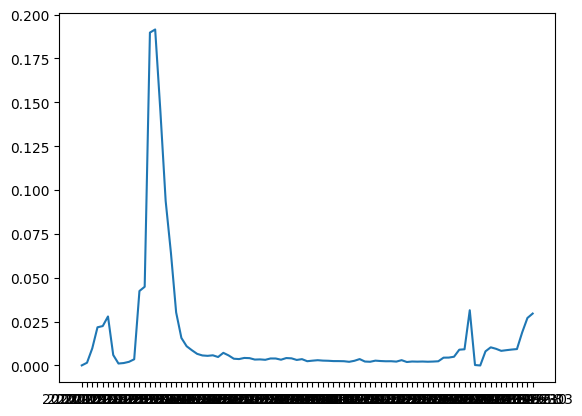

In [22]:
dfold_bc2=pd.read_csv("..\\data\\regions\\British Columbia\\epidemic\\vac_1st_age_weekly.csv")
pop=pd.read_excel("..\\data\\regions\\British Columbia\\demographic\\pop_5years.xlsx")

dfold_bc2_1=dfold_bc2.loc[dfold_bc2['age']=='70–79']
dfold_bc2_2=dfold_bc2.loc[dfold_bc2['age']=='80+']
dfold_bc2=pd.DataFrame(data=None,columns=['date','rV'])
dfold_bc2['date']=dfold_bc2_1['week_end']
dfold_bc2['rV'] = (dfold_bc2_1['rV'].values*pop.loc[pop['Age']=='70-74']['total'].values
                   +dfold_bc2_2['rV'].values*pop.loc[pop['Age']=='75+']['total'].values)/(pop.loc[pop['Age']=='70-74']['total'].values+pop.loc[pop['Age']=='75+']['total'].values)
#dfold_bc2
# dfold_bc2=pd.concat([dfold_bc2_1, dfold_bc2_2])
# dfold_bc2.rename(columns={'week_end':'date'},inplace=True)
# dfold_bc2=dfold_bc2.groupby('date').agg({'rV':'sum'})
# dfold_bc2.reset_index(inplace=True)
plt.plot(dfold_bc2['date'],dfold_bc2['rV'])

,date,rV
7,2020/12/27,2.037310e-05
17,2020/12/28,0.000000e+00
27,2020/12/29,0.000000e+00
37,2020/12/30,5.876898e-07
47,2020/12/31,5.876898e-07
...,...,...
3657,2021/12/27,1.028444e-04
3667,2021/12/28,1.273088e-04
3677,2021/12/29,1.299548e-04
3687,2021/12/30,1.336933e-04


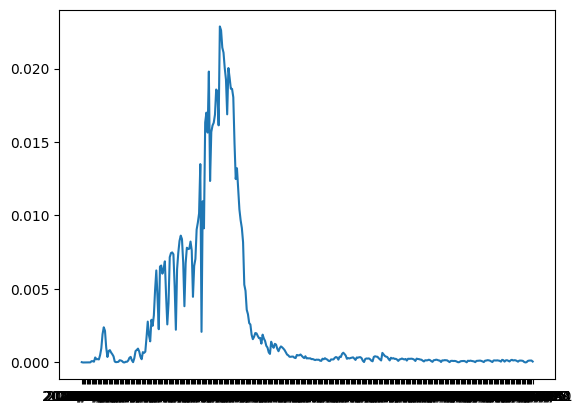

In [23]:
dfold_lom2=pd.read_csv("..\\data\\regions\\Lombardy\\epidemic\\vac_1st_age_correct_ver(agegroup_adjust).csv")
pop=pd.read_excel("..\\data\\demographic_raw\\lombardy_10year_age_group(for vaccine).xlsx")

dfold_lom2_1=dfold_lom2.loc[dfold_lom2['age']=='70-79']
dfold_lom2_2=dfold_lom2.loc[dfold_lom2['age']=='80-89']
dfold_lom2_3=dfold_lom2.loc[dfold_lom2['age']=='90+']
dfold_lom2=pd.DataFrame(data=None,columns=['date','rV'])
dfold_lom2['date']=dfold_lom2_1['date']
dfold_lom2['rV'] = (dfold_lom2_1['rV'].values*pop.loc[pop['Age']=='70-79']['total'].values
                   +dfold_lom2_2['rV'].values*pop.loc[pop['Age']=='80-89']['total'].values
                   +dfold_lom2_2['rV'].values*pop.loc[pop['Age']=='90+']['total'].values)/(pop.loc[pop['Age']=='70-79']['total'].values+pop.loc[pop['Age']=='80-89']['total'].values+pop.loc[pop['Age']=='90+']['total'].values)
plt.plot(dfold_lom2['date'],dfold_lom2['rV'])
dfold_lom2

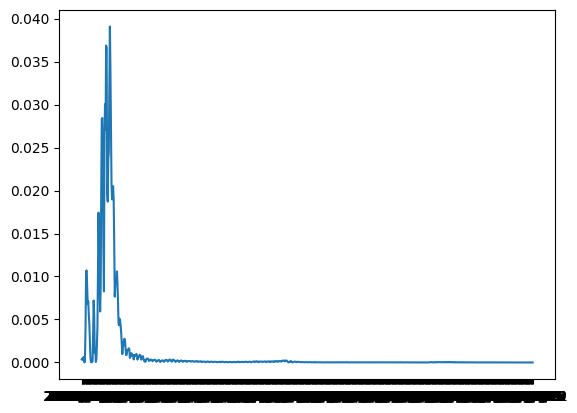

In [24]:
dfold_ld2=pd.read_csv("..\\data\\regions\\London\\epidemic\\vac_1st_age_correct_ver(agegroup_adjust).csv")
pop=pd.read_excel("..\\data\\regions\\London\\demographic\\pop_5years.xlsx")

dfold_ld2_1=dfold_ld2.loc[dfold_ld2['age_band']=='70 - 74 years']
dfold_ld2_2=dfold_ld2.loc[dfold_ld2['age_band']=='75+ years']
dfold_ld2=pd.DataFrame(data=None,columns=['date','rV'])
dfold_ld2['date']=dfold_ld2_1['date']
dfold_ld2['rV'] = (dfold_ld2_1['rV'].values*pop.loc[pop['Age']=='70-74']['total'].values
                   +dfold_ld2_2['rV'].values*pop.loc[pop['Age']=='75+']['total'].values)/(pop.loc[pop['Age']=='70-74']['total'].values+pop.loc[pop['Age']=='75+']['total'].values)
plt.plot(dfold_ld2['date'],dfold_ld2['rV'])

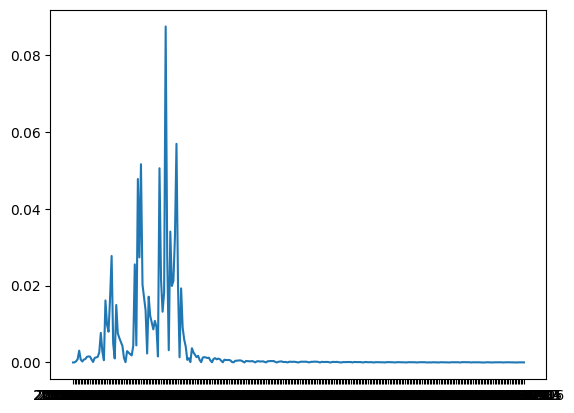

In [25]:
dfold_sp2=pd.read_csv("..\\data\\regions\\Sao Paulo\\epidemic\\vac_1st_age_correct_ver(agegroup_adjust).csv")

dfold_sp2_1=dfold_sp2.loc[dfold_sp2['agegroup']==8]
dfold_sp2=pd.DataFrame(data=None,columns=['date','rV'])
dfold_sp2['date']=dfold_sp2_1['date']
dfold_sp2['rV'] = dfold_sp2_1['rV']
plt.plot(dfold_sp2['date'],dfold_sp2['rV'])

# dfold_sp2=pd.read_csv("D:\\论文\\project 1\\code_stochastic\\data\\regions\\Sao Paulo\\epidemic\\vac_1st_age_correct_ver(agegroup_adjust).csv")
# dfold_sp2=dfold_sp2.loc[dfold_sp2['agegroup']==8]
# dfold_sp2=dfold_sp2.groupby('date').agg({'rV':'sum'})
# dfold_sp2.reset_index(inplace=True)
# plt.plot(dfold_sp2['date'],dfold_sp2['rV'])

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_46648\478122814.py:274: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax=plt.subplot2grid((17,6),(2*i,3),colspan=3,rowspan=2)


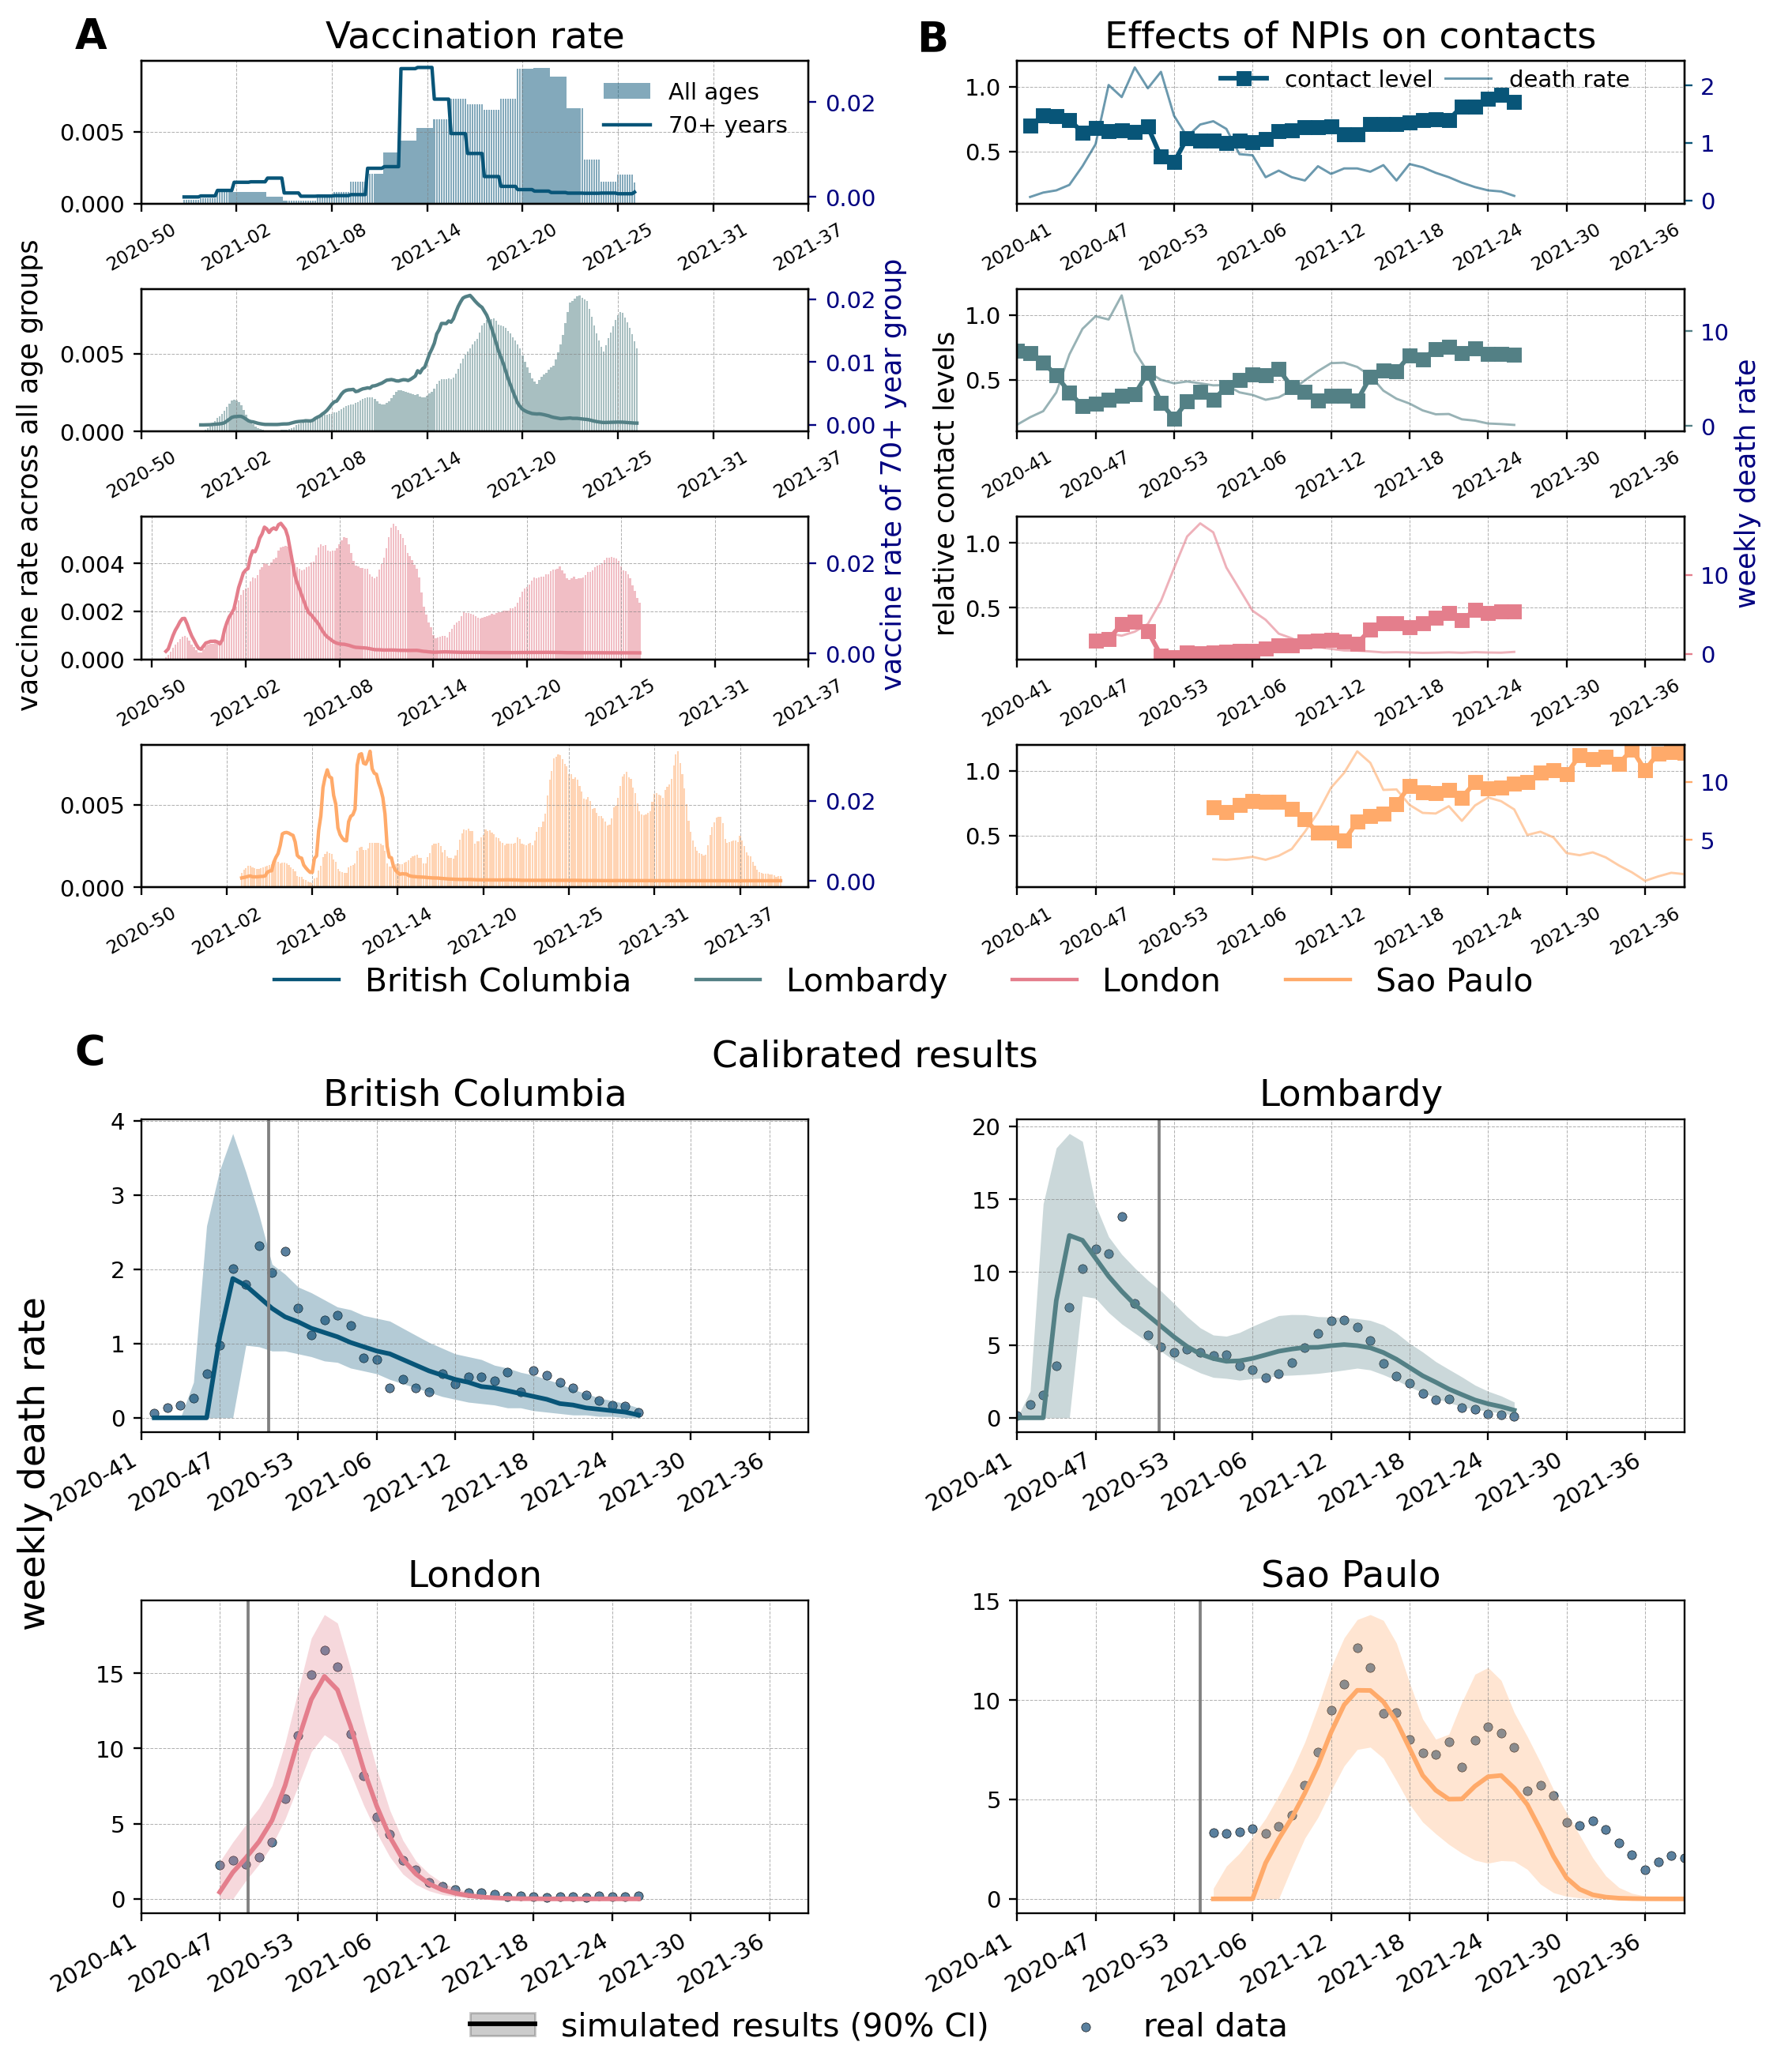

In [28]:
import matplotlib
plt.figure(dpi=210, figsize=(12,14.5))
import matplotlib.dates as mdates
################## panel A ########
dfs=[df_bc_diff, df_lom, df_ld, df_sp]
df_olds=[dfold_bc2, dfold_lom2, dfold_ld2, dfold_sp2]

for i in range(4):
    dfs[i]['date'] = dfs[i]['date'].astype('datetime64[ns]')
    df_olds[i]['date'] = df_olds[i]['date'].astype('datetime64[ns]')


from scipy.interpolate import interp1d
titles=['British Columbia', 'Lombardy', 'London', 'Sao Paulo']
#colors = ['#6CC2BD', '#5A809E', '#F57D7C', '#FEE4C4']
colors = ['#085578', '#538085', '#e47e8c', '#ffaa6a']

plot_lines=[]
m=0
min_date = datetime.datetime(2020,12,8)
max_date =datetime.datetime(2021,10,3)
dates_all = [min_date]
for delta in range(1, (max_date-min_date).days+1):
    dates_all.append(min_date+datetime.timedelta(days=delta))

df_dates_all = pd.DataFrame(dates_all, columns=['dates'])
df_dates_all['week'] = df_dates_all['dates'].dt.isocalendar().week
df_dates_all['year'] = df_dates_all['dates'].dt.isocalendar().year
year_weeks_all=[]
for d in range(0,len(dates_all)):
    if df_dates_all.iloc[d,:]['week']<=9:
        year_weeks_all.append(str(df_dates_all.iloc[d,:]['year'])+'-0'+str(df_dates_all.iloc[d,:]['week']))
    else:
        year_weeks_all.append(str(df_dates_all.iloc[d,:]['year'])+'-'+str(df_dates_all.iloc[d,:]['week']))


for i in range(4):
    if i==0:
        vax_date=datetime.datetime(2020,12,26)
        end_date=datetime.datetime(2021,7,4)
    elif i==1:
        vax_date=datetime.datetime(2020,12,27)
        end_date=datetime.datetime(2021,7,4)
    elif i==2:
        vax_date=datetime.datetime(2020,12,8)
        end_date=datetime.datetime(2021,7,4)
    else:
        vax_date=datetime.datetime(2021,1,18)
        end_date=datetime.datetime(2021,10,3)
    y=[]
    if i==3:
        dfs[i]=dfs[i].loc[dfs[i]['date']<=datetime.datetime(2021, 10, 3)]
        df_olds[i]=df_olds[i].loc[df_olds[i]['date']<=datetime.datetime(2021, 10, 3)]
    else:
        dfs[i]=dfs[i].loc[dfs[i]['date']<=datetime.datetime(2021, 7, 4)]
        df_olds[i]=df_olds[i].loc[df_olds[i]['date']<=datetime.datetime(2021, 7, 4)]
    
    #for j in range(0, len(dfs[i]['date'])):
    if i!=0:
        dates=[vax_date]
        for delta in range(1, (end_date-vax_date).days+1):
            dates.append(vax_date+datetime.timedelta(days=delta))
        dates=dates[6:]
        df_date = pd.DataFrame(dates, columns=['dates'])
        df_date['week'] = df_date['dates'].dt.isocalendar().week
        df_date['year'] =df_date['dates'].dt.isocalendar().year
        year_week_list=[]
        for d in range(0,len(dates)):
            if df_date.iloc[d,:]['week']<=9:
                year_week_list.append(str(df_date.iloc[d,:]['year'])+'-0'+str(df_date.iloc[d,:]['week']))
            else:
                year_week_list.append(str(df_date.iloc[d,:]['year'])+'-'+str(df_date.iloc[d,:]['week']))

        y=dfs[i]['rV'].rolling(7).mean()[6:].values
        y_old=df_olds[i]['rV'].rolling(7).mean()[6:].values
        ax=plt.subplot2grid((17,6),(2*m,0),colspan=3,rowspan=2)
        p1 = ax.bar(dates, y, color=colors[i], alpha=0.5)
        ax.tick_params(axis='y', color='k', labelcolor='k')
        
        #ax[m].text(1, 0.5, texts[i])
        ax1=ax.twinx()
        p2, = ax1.plot(dates, y_old, color=colors[i])
        plot_lines.append(p2)
        ax1.tick_params(axis='y', color='navy', labelcolor='navy')

        
    else:
        a=np.linspace(0, len(dfs[i])-1, len(dfs[i]))
        b=np.array(dfs[i]['rV'].values)/7
        a_new=np.linspace(0, len(dfs[i])-1, (len(dfs[i])-1)*7+1)
        f = interp1d(a,b,kind='previous')
        b_new=f(a_new)

        c=np.linspace(0, len(df_olds[i])-1, len(df_olds[i]))
        d=np.array(df_olds[i]['rV'].values)/7
        c_new=np.linspace(0, len(df_olds[i])-1, (len(df_olds[i])-1)*7+1)
        f2 = interp1d(c,d,kind='previous')
        d_new=f2(c_new)
        
        start_date=datetime.datetime(2020,12,26)
        dates=[start_date]
        for delta in range(1, (datetime.datetime(2021,7,4)-start_date).days):
            dates.append(start_date+datetime.timedelta(days=delta))
        df_date = pd.DataFrame(dates, columns=['dates'])
        df_date['week'] = df_date['dates'].dt.isocalendar().week
        df_date['year'] =df_date['dates'].dt.isocalendar().year
        year_week_list=[]
        for d in range(0,len(dates)):
            if df_date.iloc[d,:]['week']<=9:
                year_week_list.append(str(df_date.iloc[d,:]['year'])+'-0'+str(df_date.iloc[d,:]['week']))
            else:
                year_week_list.append(str(df_date.iloc[d,:]['year'])+'-'+str(df_date.iloc[d,:]['week']))
                
        ax=plt.subplot2grid((17,6),(2*m,0),colspan=3,rowspan=2)
        p1 = ax.bar(dates, b_new, color=colors[i], alpha=0.5, width=0.8)
        ax.tick_params(axis='y', color='k', labelcolor='k')
        ax.set_ylabel('vaccine rate across all age groups', color='k',  y=-1.9, labelpad=7, size=12)
        #ax[m].text(1, 0.5, texts[i])
        #print(len(b_new))
        ax1=ax.twinx()
        p2, = ax1.plot(dates, d_new[:-7], color=colors[i])
        plot_lines.append(p2)
        ax1.tick_params(axis='y', color='navy', labelcolor='navy')
        ax1.set_ylabel('vaccine rate of 70+ year group', color='navy', size=12, y=-1.9, labelpad=2)

        ax.legend([p1, p2], ["All ages", "70+ years"], frameon=False, ncol=1, fontsize=10)
        ax.set_title('Vaccination rate',fontsize=16)
        ax.annotate("A", xy=(-0.1, 1.17), xycoords='axes fraction', fontsize=18, va='center', ha='left', weight="bold")

    ax.grid(color='grey', linestyle='--', linewidth=0.35, alpha=0.6, axis="both")
    ax.set_xticks(dates_all[::40])
    ax.set_xticklabels(year_weeks_all[::40], rotation=30, fontsize=8)
    m+=1
ax.legend([plot_lines[0], plot_lines[1], plot_lines[2], plot_lines[3]], ["British Columbia", "Lombardy", "London", "Sao Paulo"], 
              frameon=False, fontsize=14, bbox_to_anchor=[1.13, -1.35,1,1], ncols=4)
# plt.subplots_adjust(hspace=0.5)
# plt.show()



## preparation for panel B and pandel C
def generate_year_weeks(start_yw, end_yw):
    """
    Generate a list of year-week strings between start_yw and end_yw.
    Handles the transition from 2020-52 through 2020-53 to 2021-01.
    
    Parameters:
    start_yw (str): Start year-week in format 'YYYY-WW'
    end_yw (str): End year-week in format 'YYYY-WW'
    
    Returns:
    list: List of year-week strings
    """
    start_year, start_week = map(int, start_yw.split('-'))
    end_year, end_week = map(int, end_yw.split('-'))
    
    year_weeks = []
    current_year = start_year
    current_week = start_week
    
    while True:
        # 添加当前周到列表
        year_weeks.append(f"{current_year}-{current_week:02d}")
        
        # 检查是否到达终点
        if current_year == end_year and current_week == end_week:
            break
            
        # 更新到下一周
        if current_year == 2020 and current_week == 52:
            current_week = 53
        elif current_year == 2020 and current_week == 53:
            current_year = 2021
            current_week = 1
        else:
            current_week += 1
            if current_week > 52:
                current_year += 1
                current_week = 1
    
    return year_weeks

def week_to_date(year_week):
    """
    Convert year-week format (e.g. '2020-52') to datetime object.
    Special mapping:
    2020-52 -> 2020-12-28
    2020-53 -> 2021-01-04
    2021-01 -> 2021-01-11
    
    Parameters:
    year_week (str): Year and week in format 'YYYY-WW'
    
    Returns:
    datetime: Date object representing the Monday of that week
    """
    year, week = map(int, year_week.split('-'))

    if year == 2020 and week == 52:
        return datetime.datetime(2020, 12, 28)
    elif year == 2020 and week == 53:
        return datetime.datetime(2021, 1, 4)
    elif year == 2021 and week == 1:
        return datetime.datetime(2021, 1, 11)
    else:
        if year == 2021:
            base_date = datetime.datetime(2021, 1, 11)
            return base_date + datetime.timedelta(weeks=(week-1))
        else:
            base_date = datetime.datetime(2020, 12, 28)
            weeks_diff = week - 52
            return base_date + datetime.timedelta(weeks=weeks_diff)

global_start_yw = '2020-41'  # start of Lombardy
global_end_yw = '2021-39'    # end of Sao Paulo
all_year_weeks = generate_year_weeks(global_start_yw, global_end_yw)
all_dates = [week_to_date(yw) for yw in all_year_weeks]
################## panel B #################

ax=plt.subplot2grid((17,6),(0,3),colspan=3,rowspan=8)
colors = ['#085578', '#538085', '#e47e8c', '#ffaa6a']
reductions=[reduction_bc, reduction_lom, reduction_london, reduction_sp]
i=0
# k=0
overall_deltas_regions=[]
plot_lines=[]
for region in ["British Columbia", "Lombardy", "London",  "Sao Paulo"]:
    if region=='British Columbia':
        start_yw, end_yw ='2020-42', '2021-26'
        vaccine_date=datetime.datetime(2020,12,19)
        start_date=datetime.datetime(2020,10,19)
        #alpha_date=datetime.datetime(2020,12,21)
    if region=='Lombardy':
        start_yw, end_yw ='2020-41', '2021-26'
        vaccine_date=datetime.datetime(2020,12,27)
        start_date=datetime.datetime(2020,9,14)
        #alpha_date=datetime.datetime(2020,9,28)
    if region=='London':
        start_yw, end_yw ='2020-47', '2021-26'
        vaccine_date=datetime.datetime(2020,12,8)
        start_date=datetime.datetime(2020,12,7)
    if region=='Sao Paulo':
        start_yw, end_yw ='2021-03', '2021-39'
        vaccine_date=datetime.datetime(2021,1,18)
        start_date=datetime.datetime(2021,1,18)
        #alpha_date=datetime.datetime(2021,3,29)

    df=pd.read_csv("D:/论文/project 1/code/data/regions/" + region + "/epidemic/deaths.csv")

    if region=="British Columbia":
        start_yw, end_yw = "2020-42", "2021-26"
    elif region=="Lombardy":
        start_yw, end_yw = "2020-41", "2021-26"
    if region=="London":
        start_yw, end_yw = "2020-47", "2021-26"
    if region=="Sao Paulo":
        start_yw, end_yw = "2021-03", "2021-39"

    df=pd.read_csv("D:/论文/project 1/code_stochastic/data/regions/" + region + "/epidemic/deaths.csv")
    death_real=df.loc[(df["year_week"] >= start_yw) & \
                                         (df["year_week"] <= end_yw)]["deaths"].values
    real_date=df.loc[(df["year_week"] >= start_yw) & \
                                         (df["year_week"] <= end_yw)]["year_week"].values

    
    #calculate deaths per 10,000 persons
    pop=pd.read_excel(f'../data/regions/{region}/demographic/pop_5years.xlsx')
    pop_total=pop['total'].sum()
    death_real = death_real/pop_total*100000
    # death_sim = death_sim/pop_total*100000

    reduction=reductions[i].loc[(reductions[i].index >= start_yw) & (reductions[i].index <= end_yw)].values
    #date=reductions[i].loc[(reductions[i].index >= start_yw) & (reductions[i].index <= end_yw)].index
    ax=plt.subplot2grid((17,6),(2*i,3),colspan=3,rowspan=2)

    year_weeks = [week_to_date(year_week) for year_week in real_date]
    p1, = ax.plot(year_weeks, reduction, color=colors[i], linewidth=2, marker='s', markeredgecolor=colors[i], markersize=5.5)

    if i==0:
        ax.set_title("Effects of NPIs on contacts", fontsize=16)
        ax.annotate("B", xy=(-0.15, 1.15), xycoords='axes fraction', fontsize=18, va='center', ha='left', weight="bold")

    ax.set_ylim(0.1,1.2)

    ax.grid(color='grey', linestyle='--', linewidth=0.35, alpha=0.6, axis="both")

    ax1 = ax.twinx()
    
    p2, = ax1.plot(year_weeks, death_real, color=colors[i], alpha=0.6, linewidth=1)
    ax1.tick_params(axis='y', color=colors[i], labelcolor='navy')

    ax.set_xticks(all_dates[::6])
    ax.set_xticklabels(all_year_weeks[::6], rotation=30, fontsize=8)
    ax.set_xlim(min(all_dates), max(all_dates))
    if i == 0:
        ax.legend([p1, p2], ["contact level", "death rate"], frameon=False, ncol=2, bbox_to_anchor=(0.95, 1.09), loc='upper right',  columnspacing=0.5)
        #ax.legend([p1, p2], ["contact level", "death rate"], frameon=False, ncol=2, fontsize=10, loc="upper center", bbox_to_anchor=(0.3, 0.55, 0.5, 0.5))
    i+=1
ax.set_ylabel('relative contact levels', color='k', size=12, y=2.84, labelpad=2)
ax1.set_ylabel('weekly death rate', color='navy', size=12, y=2.84, labelpad=2)

################## panel C ########
i,j =11,0
k=0
different_starts=[17, 23, 3, 8]

for region in ["British Columbia", "Lombardy","London", "Sao Paulo"]:
    if region=='British Columbia':
        start_yw, end_yw ='2020-42', '2021-26'
        vaccine_date=datetime.datetime(2020,12,19)
        start_date=datetime.datetime(2020,10,12)
    if region=='Lombardy':
        start_yw, end_yw ='2020-41', '2021-26'
        vaccine_date=datetime.datetime(2020,12,27)
        start_date=datetime.datetime(2020,10,5)
    if region=='London':
        start_yw, end_yw ='2020-47', '2021-26'
        vaccine_date=datetime.datetime(2020,12,8)
        start_date=datetime.datetime(2020,11,23)
    if region=='Sao Paulo':
        start_yw, end_yw ='2021-03', '2021-39'
        vaccine_date=datetime.datetime(2021,1,18)
        start_date=datetime.datetime(2021,1,18)
    
    df=pd.read_csv("D:/论文/project 1/code_stochastic/data/regions/" + region + "/epidemic/deaths.csv")
    death_real=df.loc[(df["year_week"] >= start_yw) & \
                      (df["year_week"] <= end_yw)]["deaths"].values
    real_date=df.loc[(df["year_week"] >= start_yw) & \
                     (df["year_week"] <= end_yw)]["year_week"].values

    files=os.listdir('D:/论文/project 1/code_stochastic/model/posteriors/new4_final/')
    confile1=[file for file in files if region in file and '_06_' in file and '.npz' in file][0]
    path = 'D:/论文/project 1/code_stochastic/model/posteriors/new4_final/'
    death_sim=np.load(path+confile1)["arr_0"]
    
    # 计算deaths per 100,000
    pop=pd.read_excel(f'../data/regions/{region}/demographic/pop_5years.xlsx')
    pop_total=pop['total'].sum()
    death_real = death_real/pop_total*100000
    death_sim = death_sim/pop_total*100000
    
    ax2=plt.subplot2grid((20,6),(i,j),colspan=3,rowspan=4)
    if region=='British Columbia':
        ax2.annotate("Calibrated results", xy=(1.1, 1.2), xycoords='axes fraction', rotation=0, fontsize=16, va='center', ha='center')
        ax2.annotate("C", xy=(-0.1, 1.21), xycoords='axes fraction', fontsize=18, va='center', ha='left', weight="bold")
    # 绘制数据点和线条
    year_weeks = [week_to_date(year_week) for year_week in real_date]
    p0 = ax2.scatter(year_weeks, death_real, color="#5A809E", edgecolor="black",s=15,linewidth=0.2)
    p1, = ax2.plot(year_weeks, np.quantile(death_sim, axis=0, q=0.5), color=colors[k], alpha=1,linewidth=2)
    p2 = ax2.fill_between(year_weeks, np.quantile(death_sim, axis=0, q=0.05), 
                         np.quantile(death_sim, axis=0, q=0.95), color=colors[k], alpha=0.3, linewidth=0)

    ax2.axvline(vaccine_date, color='grey', alpha=1, linewidth=1.3)
    
    # 设置统一的x轴刻度和标签
    # 每4周显示一个刻度
    xtick_locations = all_dates[::6]  # 调整数字可以改变标签密度
    xtick_labels = all_year_weeks[::6]
    
    ax2.set_xticks(xtick_locations)
    ax2.set_xticklabels(xtick_labels, rotation=30, ha='right')
    
    if region=="British Columbia":
        ax2.set_ylabel("weekly death rate",fontsize=16, y=-0.1, labelpad= 25)
    
    ax2.grid(color='grey', linestyle='--', linewidth=0.35, alpha=0.6, axis="both")
    ax2.set_title(region, fontsize=16)
    # 设置统一的x轴范围
    ax2.set_xlim(min(all_dates), max(all_dates))

    j+=3 
    if j==6:
        j=0
        i+=5
    k+=1
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
p1_legend = mlines.Line2D([], [], color='black', linewidth=2)
p2_legend = mpatches.Patch(color='black', alpha=0.2)
#ax2=plt.subplot2grid((8,6),(6,0),colspan=3,rowspan=2)
ax2.legend([(p1_legend,p2_legend), p0], ["simulated results (90% CI)", "real data"],bbox_to_anchor=[0.35, -0.32,0.1,0.1], frameon=False, ncol=3, fontsize=14)
#plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(3))
#plt.spines['top'].set_visible(False)
#plt.spines['right'].set_visible(False)
#plt.tight_layout(h_pad=8)
plt.subplots_adjust(hspace=3, wspace=2.5)
plt.savefig(r'.\figures\vaccine2.pdf', bbox_inches="tight")